In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage

In [2]:
PATH = '../../data/yoga'

In [3]:
img_pd = pd.read_csv(PATH + '/yoga.csv', index_col=0)

In [4]:
img_pd.head()

,original_name,processed_name,original_path,processed_path,test_train,class
0,00000000.jpg,downdog_0.jpg,../../data/yoga/DATASET/TEST/downdog/00000000.jpg,../../data/yoga/PROCESSED/downdog_0.jpg,TEST,downdog
1,00000000.jpg,downdog_0_flipped.jpg,../../data/yoga/DATASET/TEST/downdog/00000000.jpg,../../data/yoga/PROCESSED/downdog_0.jpg,TEST,downdog
2,00000001.JPG,downdog_1.jpg,../../data/yoga/DATASET/TEST/downdog/00000001.JPG,../../data/yoga/PROCESSED/downdog_1.jpg,TEST,downdog
3,00000001.JPG,downdog_1_flipped.jpg,../../data/yoga/DATASET/TEST/downdog/00000001.JPG,../../data/yoga/PROCESSED/downdog_1.jpg,TEST,downdog
4,00000002.jpg,downdog_2.jpg,../../data/yoga/DATASET/TEST/downdog/00000002.jpg,../../data/yoga/PROCESSED/downdog_2.jpg,TEST,downdog


In [5]:
X = []
img_paths = img_pd.processed_path.to_list()
for img_path in tqdm(img_paths):
    X.append(np.asarray(Image.open(img_path)))

100%|██████████| 3100/3100 [00:06<00:00, 451.60it/s]


In [6]:
y = img_pd['class'].to_list()

In [7]:
def process_sample(x):
    return skimage.feature.hog(x,
                             visualize=False,
                             channel_axis=-1)

In [8]:
from joblib import Parallel, delayed

# X_hog = []

X_hog = Parallel(n_jobs=-2, verbose=1)(delayed(process_sample)(sample) for sample in X)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-2)]: Done 250 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-2)]: Done 750 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-2)]: Done 1450 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-2)]: Done 2350 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-2)]: Done 3100 out of 3100 | elapsed:   20.1s finished


In [9]:
y_unique = np.unique(y).tolist()

In [10]:
y_unique

['downdog', 'goddess', 'plank', 'tree', 'warrior2']

In [11]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

lb.fit(y_unique)

y_encoded = lb.transform(y)

In [12]:
y_encoded

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, shuffle=True, stratify=y)

In [14]:
from sklearn.svm import SVC

clf = SVC(verbose=1)
clf.fit(X_train, y_train)


[LibSVM]

SVC(verbose=1)

In [15]:
y_pred = clf.predict(X_test)

In [16]:
# y_pred2 = lb.inverse_transform(y_pred)

In [17]:
# y_test2 = lb.inverse_transform(y_test)

0.964516129032258


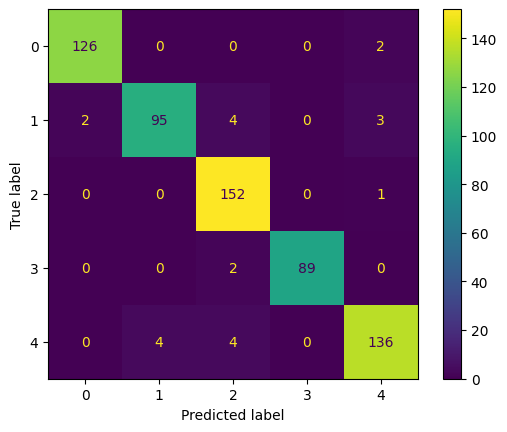

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(cm)
display.plot()

In [19]:
import pickle

with open('../../models/svm', 'wb') as f:
    pickle.dump(clf, f)